In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

Using TensorFlow backend.


In [2]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [3]:
import pandas as pd

df = pd.DataFrame(trainy)
df[0].unique()

array([9, 0, 3, 2, 7, 5, 1, 6, 4, 8], dtype=uint8)

In [4]:
in_label = Input(shape=(1,))
# embedding for categorical input
li = Embedding(10, 50)(in_label)
# scale up to image dimensions with linear activation
n_nodes = 28 * 28
li = Dense(n_nodes)(li)
# reshape to additional channel
li = Reshape((28, 28, 1))(li)
# image input
in_image = Input(shape=(28,28,1))
# concat label as a channel
merge = Concatenate()([in_image, li])
# downsample
fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
fe = LeakyReLU(alpha=0.2)(fe)
# downsample
fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
fe = LeakyReLU(alpha=0.2)(fe)
# flatten feature maps
fe = Flatten()(fe)
# dropout
fe = Dropout(0.4)(fe)
# output
out_layer = Dense(1, activation='sigmoid')(fe)
# define model
discriminator = Model([in_image, in_label], out_layer)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [5]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
____________________________________________________________________________________________

In [6]:
in_label = Input(shape=(1,))
# embedding for categorical input
li = Embedding(10, 50)(in_label)
# linear multiplication
n_nodes = 7 * 7
li = Dense(n_nodes)(li)
# reshape to additional channel
li = Reshape((7, 7, 1))(li)
# image generator input
in_lat = Input(shape=(100,))
# foundation for 7x7 image
n_nodes = 128 * 7 * 7
gen = Dense(n_nodes)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((7, 7, 128))(gen)
# merge image gen and label input
merge = Concatenate()([gen, li])
# upsample to 14x14
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
gen = LeakyReLU(alpha=0.2)(gen)
# upsample to 28x28
gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
# output
out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
# define model
generator = Model([in_lat, in_label], out_layer)

In [7]:
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

In [8]:
discriminator.trainable = False
# get noise and label inputs from generator model
gen_noise, gen_label = generator.input
# get image output from the generator model
gen_output = generator.output
# connect image output and label input from generator as inputs to discriminator
gan_output = discriminator([gen_output, gen_label])
# define gan model as taking noise and label and outputting a classification
gan = Model([gen_noise, gen_label], gan_output)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=opt)

In [9]:
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

In [10]:
for i in range(2):
		# enumerate batches over the training set
  for j in range(60000//64):
    # get randomly selected 'real' samples


    ix = randint(0, 60000, 32)
    # select images and labels
    X_real, labels_real = trainX[ix], trainy[ix]

    X_real = expand_dims(X_real, axis=-1)
    # convert from ints to floats
    X_real = X_real.astype('float32')
    # scale from [0,255] to [-1,1]
    X_real = (X_real - 127.5) / 127.5
    # generate class labels
    y_real = ones((32, 1))

    # update discriminator model weights
    d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
    # generate 'fake' examples


    x_input = randn(100 * 32)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(32, 100)
    # generate labels
    labels = randint(0, 10, 32)

    X_fake = generator.predict([z_input, labels])
    # create class labels
    y_fake = zeros((32, 1))


    # update discriminator model weights
    d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
    # prepare points in latent space as input for the generator

    x_input = randn(100 * 64)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(64, 100)
    # generate labels
    labels = randint(0, 10, 64)

    # create inverted labels for the fake samples
    y_gan = ones((64, 1))
    # update the generator via the discriminator's error
    g_loss = gan.train_on_batch([z_input, labels], y_gan)
    # summarize loss on this batch
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, 60000//64, d_loss1, d_loss2, g_loss))
# save the generator model

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


>1, 1/937, d1=0.705, d2=0.696 g=0.691
>1, 2/937, d1=0.624, d2=0.698 g=0.690
>1, 3/937, d1=0.560, d2=0.700 g=0.690
>1, 4/937, d1=0.494, d2=0.700 g=0.691
>1, 5/937, d1=0.432, d2=0.697 g=0.694
>1, 6/937, d1=0.381, d2=0.694 g=0.698
>1, 7/937, d1=0.334, d2=0.699 g=0.691
>1, 8/937, d1=0.261, d2=0.722 g=0.671
>1, 9/937, d1=0.224, d2=0.772 g=0.630
>1, 10/937, d1=0.185, d2=0.847 g=0.580
>1, 11/937, d1=0.186, d2=0.944 g=0.529
>1, 12/937, d1=0.180, d2=1.029 g=0.506
>1, 13/937, d1=0.173, d2=1.011 g=0.551
>1, 14/937, d1=0.213, d2=0.917 g=0.638
>1, 15/937, d1=0.219, d2=0.739 g=0.785
>1, 16/937, d1=0.271, d2=0.607 g=0.967
>1, 17/937, d1=0.275, d2=0.504 g=1.136
>1, 18/937, d1=0.309, d2=0.380 g=1.299
>1, 19/937, d1=0.343, d2=0.343 g=1.296
>1, 20/937, d1=0.266, d2=0.379 g=1.265
>1, 21/937, d1=0.327, d2=0.428 g=1.096
>1, 22/937, d1=0.265, d2=0.505 g=0.935
>1, 23/937, d1=0.296, d2=0.582 g=0.821
>1, 24/937, d1=0.269, d2=0.657 g=0.745
>1, 25/937, d1=0.215, d2=0.716 g=0.683
>1, 26/937, d1=0.233, d2=0.794 g=0

NameError: ignored

In [11]:
generator.save('cgan_generator.h5')

In [17]:
import numpy
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

In [22]:
x_input = randn(100 * 100)
# reshape into a batch of inputs for the network
z_input = x_input.reshape(100, 100)
# generate labels
labels = numpy.ones(100) + numpy.ones(100)

In [23]:
model = load_model('cgan_generator.h5')

X  = model.predict([z_input, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


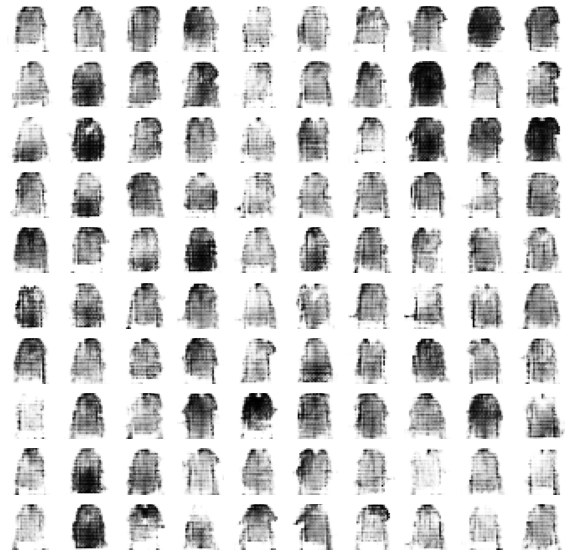

In [27]:
pyplot.figure(figsize=(10,10))
for i in range(10 * 10):
  # define subplot
  pyplot.subplot(10, 10, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()